**<font size=6>使用线性回归对Airbnb的房价预测</font>**

<font size=4 color="gray">是什么决定了Airbnb的租金价格？床位数？允许的客人数？评论分数？</font>

**问题：**如何预测Airbnb的租金？

**数据：**Kaggle数据集，数据集包含很多特征：床位数、允许的访客数、描述、评论分数等其他特征。

**方法：**回归预测，使用线性回归模型。

**<font size=5>step 0：分析问题与获取数据集</font>**

Why am I doing this analysis? What's the goal? What relationships between features and the target?

In [1]:
#import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lars_path
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score
import scipy.stats as stats

**What it is R2?**

首先介绍一下SSE、SSR、SST

**SSE:** 预测值和真值相差的平方和是SSE,也就是误差平方和，这肯定是越小越好了，相当于一个误差累计。当然这个SSE越接近于0越好。

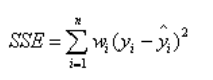

**SSR:** 预测值和原始值的均值差得平方和

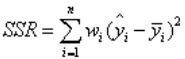

**SST:** 原始数据和原始数据的均值的差的平方和

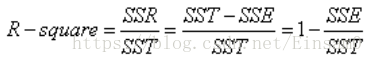

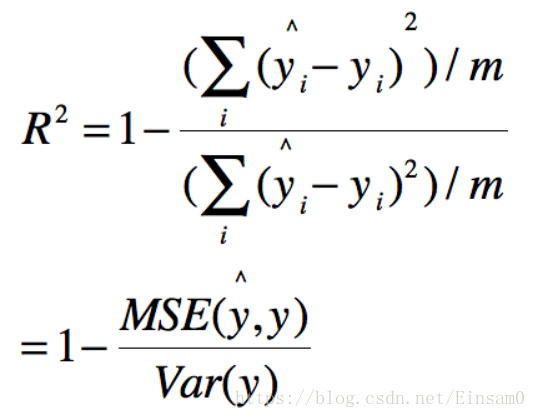

R2的范围在0-1之间，越接近1，表示越好，一般衡量线性回归最好的指标应该就是R2，通常表示模型拟合的好坏。对R2开根号，就是R，也就是相关系数，也是越近1越好。

In [2]:
#import plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**<font size=5>step 1：利用Pandas对数据进行一些探索性分析</font>**

**EDA（exploratory data analysis）steps：**

1. 利用pd.describe()查看数据的相关统计值，以及pd.info()查看数据中是否含有缺失值以及每个特征的值的数量

2. 整理具有空格的特征名

3. 将某些特征与类别结合起来。例如，"property_type"具有25个不同的类别（**使用pd.value_counts（）进行查看**）。我将最低的23种归为“其他”类别。这也是在其他一些功能上完成的。这很有帮助，因为我没有从dummy coding中创建20多个新列。

4. 删除一些分布不均匀unevenly或者无法使用的数据特征,例如, "host_has_profile_pic"具有32k"是"而只有97个"否"。这在模型中将无法使用

5. 进一步检查丢失的数据字段。对于一些很重要的特征(例如“review_scores_rating”)，利用中位数进行填充。

6. **使用pd.corr()查看相关性**，并使用热力图heatmap查看特征与结果之间和特征与特征之间的相关性。

①读取数据

In [3]:
data = pd.read_csv("Airbnbdataset.csv", header=0, encoding="utf-8")

In [4]:
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


②利用pd.describe()查看数据的相关统计信息（**<font color="red">注意：只有数值型数据的相关统计信息</font>**）

In [5]:
data.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


利用pd.info()查看是否有缺失值, 以及数据的类型

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

可以发现这里有缺失值

或者可以使用pd.count()直接查看各个字段的数据量

In [7]:
data.count()

id                        74111
log_price                 74111
property_type             74111
room_type                 74111
amenities                 74111
accommodates              74111
bathrooms                 73911
bed_type                  74111
cancellation_policy       74111
cleaning_fee              74111
city                      74111
description               74111
first_review              58247
host_has_profile_pic      73923
host_identity_verified    73923
host_response_rate        55812
host_since                73923
instant_bookable          74111
last_review               58284
latitude                  74111
longitude                 74111
name                      74111
neighbourhood             67239
number_of_reviews         74111
review_scores_rating      57389
thumbnail_url             65895
zipcode                   73145
bedrooms                  74020
beds                      73980
dtype: int64

使用pd.dtypes属性直接查看各个字段的类型

In [8]:
data.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

③查看特征名

In [9]:
data.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

④使用pd.value_counts()查看分类型数据的类别及其对应的数据量

In [10]:
data["property_type"].value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Cave                      2
Train                     2
Island                    1
Parking Space             1
Lighthouse                1
Casa particular           1
Name: property_type,

In [11]:
len(data["property_type"].value_counts())

35

发现这是个严重不平衡数据，一共有35种类别，可以考虑将下面的23种类别标记为其他。

⑤删除一些无用的字段

In [12]:
data["host_has_profile_pic"].value_counts()

t    73697
f      226
Name: host_has_profile_pic, dtype: int64

这个字段严重不平衡，可以考虑删除

In [13]:
data = data.drop(["host_has_profile_pic"], axis=1)

In [14]:
data.shape

(74111, 28)

⑥对重要的特征的缺失值进行填充

对于review_scores_rating这个字段，利用中位数进行填充

In [15]:
median = data["review_scores_rating"].median()

In [16]:
data["review_scores_rating"].fillna(median, inplace=True)

In [81]:
bathroom_median = data["bathrooms"].median()
bedroom_median = data["bedrooms"].median()
beds_median = data["beds"].median()

In [82]:
data["bathrooms"].fillna(bathroom_median, inplace=True)

In [83]:
data["bedrooms"].fillna(bedroom_median, inplace=True)

In [84]:
data["beds"].fillna(beds_median, inplace=True)

In [85]:
data.count()

id                                     74111
log_price                              74111
accommodates                           74111
bathrooms                              74111
cleaning_fee                           74111
latitude                               74111
longitude                              74111
number_of_reviews                      74111
review_scores_rating                   74111
bedrooms                               74111
beds                                   74111
cancellation_policy_flexible           74111
cancellation_policy_moderate           74111
cancellation_policy_strict             74111
cancellation_policy_super_strict_30    74111
cancellation_policy_super_strict_60    74111
property_type_Apartment                74111
property_type_Condominium              74111
property_type_House                    74111
property_type_Loft                     74111
property_type_Townhouse                74111
property_type_others                   74111
room_type_

利用pd.corr()得到整个数据集各个特征之间的相关系数矩阵

In [17]:
corr = data.corr()

查看与目标结果的一些相关特征信息

In [18]:
corr["log_price"].sort_values(ascending=False)

log_price               1.000000
accommodates            0.567574
bedrooms                0.473212
beds                    0.442153
bathrooms               0.355420
cleaning_fee            0.111191
review_scores_rating    0.084180
latitude               -0.002193
id                     -0.007178
number_of_reviews      -0.032470
longitude              -0.047529
Name: log_price, dtype: float64

利用热力图查看

In [19]:
plt.figure(figsize=(20,15))

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

**<font color="red">热力图也只是针对数值型数据呦</font>**

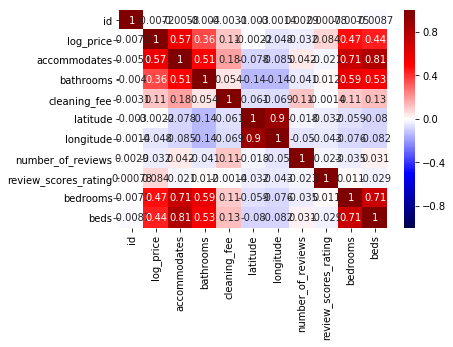

In [20]:
sns.heatmap(corr, cmap="seismic", annot=True, vmin=-1, vmax=1)

In [21]:
%matplotlib

Using matplotlib backend: Qt5Agg


⑧处理类别型字段

dummy编码可以用于处理分类型数据，使用pd.get_dummies()即可实现dummy编码。确保设置drop_first=True，不包含参考项。

In [22]:
data["cancellation_policy"].value_counts()

strict             32374
flexible           22545
moderate           19063
super_strict_30      112
super_strict_60       17
Name: cancellation_policy, dtype: int64

发现这个字段一共有五种类型

In [23]:
data["room_type"].value_counts()

Entire home/apt    41310
Private room       30638
Shared room         2163
Name: room_type, dtype: int64

room_type字段有3种类型

In [24]:
data["bed_type"].value_counts()

Real Bed         72028
Futon              753
Pull-out Sofa      585
Airbed             477
Couch              268
Name: bed_type, dtype: int64

bed_type字段有5种类型

In [25]:
data["property_type"].value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Cave                      2
Train                     2
Island                    1
Parking Space             1
Lighthouse                1
Casa particular           1
Name: property_type,

将前5大类单独存储，其余类别标记为others

In [26]:
propertylist = ["Apartment", "House", "Condominium", "Townhouse", "Loft"]

In [27]:
m, n = data.shape

In [28]:
data["property_type"].iloc[0] in propertylist == False

False

In [29]:
for i in range(m):
    if data["property_type"].iloc[i] in propertylist:
        continue
    else:
        data["property_type"].iloc[i] = "others"

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
data["property_type"].value_counts()

Apartment      49003
House          16511
others          3003
Condominium     2658
Townhouse       1692
Loft            1244
Name: property_type, dtype: int64

可以发现，把其他的都标记为了Others类

前面我们说了，准备把后面的23中标记为others

In [31]:
data = pd.get_dummies(data, columns=["cancellation_policy", "property_type", "room_type" , "bed_type"])

In [32]:
data.head()

,id,log_price,amenities,accommodates,bathrooms,cleaning_fee,city,description,first_review,host_identity_verified,...,property_type_Townhouse,property_type_others,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,6901257,5.010635,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,...,0,0,1,0,0,0,0,0,0,1
1,6304928,5.129899,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,f,...,0,0,1,0,0,0,0,0,0,1
2,7919400,4.976734,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,...,0,0,1,0,0,0,0,0,0,1
3,13418779,6.620073,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,True,SF,This light-filled home-away-from-home is super...,NaN,t,...,0,0,1,0,0,0,0,0,0,1
4,3808709,4.744932,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,...,0,0,1,0,0,0,0,0,0,1


属于相应的类别时，值才为1，否则为0

In [33]:
data.columns

Index(['id', 'log_price', 'amenities', 'accommodates', 'bathrooms',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'property_type_Apartment',
       'property_type_Condominium', 'property_type_House',
       'property_type_Loft', 'property_type_Townhouse', 'property_type_others',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed'],
      dtype='object')

⑨将含空格的列名用下划线处理

In [34]:
data.rename(columns={'room_type_Entire home/apt':'room_type_Entire_home/apt', 
                            'room_type_Private room':'room_type_Private_room',
                            'room_type_Shared room':'room_type_Shared_room'}, inplace = True)

⑩确保目标变量是正态分布，峰度和偏度均为正态

sns.displot()绘制目标值的分布情况

**stats.probplot()绘制PP图**<br>根据变量的累积概率对应于所指定的理论分布累积概率绘制的散点图，用于直观地检测样本数据是否符合某一概率分布。如果被检验的数据符合所指定的分布，则代表样本数据的点应当基本在代表理论分布的对角线上。

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
D:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


偏度Skewness： 0.5146954132526429
峰值Kurtosis： 0.6606082829340827


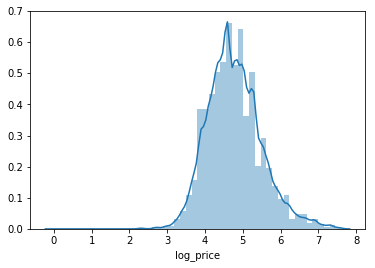

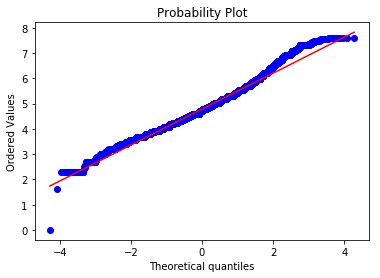

In [35]:
sns.distplot(data["log_price"], kde=True)
fig = plt.figure()
res = stats.probplot(data["log_price"], plot=plt)
print("偏度Skewness：", data["log_price"].skew())
print("峰值Kurtosis：", data["log_price"].kurt())


删除一些字符字段

In [56]:
data = data.drop(["amenities","city","description","first_review","host_identity_verified","host_response_rate",
                  "host_since","instant_bookable","last_review","name", "neighbourhood","thumbnail_url","zipcode"], axis=1)

**<font size=5>step 2：在统计模型中运行最小二乘法并验证线性回归的假设</font>**

StatsModels中的OLS模型将为我们提供最简单的（非正则化）线性回归模型，以此作为我们未来模型的基础。从简单开始然后增加复杂性总是好的。

**·** 用Patsy创建特征矩阵。Patsy很不错，因为它以简单的R语法创建了我们的模型。默认情况下，它还会在模型中添加一个拦截器（如果您不使用Patsy，请确保手动添加一个拦截器）。

**·** 训练/测试分割数据。80％的人将接受培训，而20％的人将进行测试（有关为何以后没有进行验证拆分的更多信息）。

**·** 运行OLS模型

In [77]:
data.columns

Index(['id', 'log_price', 'accommodates', 'bathrooms', 'cleaning_fee',
       'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
       'bedrooms', 'beds', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'property_type_Apartment',
       'property_type_Condominium', 'property_type_House',
       'property_type_Loft', 'property_type_Townhouse', 'property_type_others',
       'room_type_Entire_home/apt', 'room_type_Private_room',
       'room_type_Shared_room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out_Sofa', 'bed_type_Real_Bed'],
      dtype='object')

In [78]:
data.rename(columns={'bed_type_Pull-out Sofa':'bed_type_Pull-out_Sofa', 
                            'bed_type_Real Bed':'bed_type_Real_Bed'}, inplace = True)

In [86]:
data.dtypes

id                                       int64
log_price                              float64
accommodates                             int64
bathrooms                              float64
cleaning_fee                              bool
latitude                               float64
longitude                              float64
number_of_reviews                        int64
review_scores_rating                   float64
bedrooms                               float64
beds                                   float64
cancellation_policy_flexible             uint8
cancellation_policy_moderate             uint8
cancellation_policy_strict               uint8
cancellation_policy_super_strict_30      uint8
cancellation_policy_super_strict_60      uint8
property_type_Apartment                  uint8
property_type_Condominium                uint8
property_type_House                      uint8
property_type_Loft                       uint8
property_type_Townhouse                  uint8
property_type

In [87]:
data.count()

id                                     74111
log_price                              74111
accommodates                           74111
bathrooms                              74111
cleaning_fee                           74111
latitude                               74111
longitude                              74111
number_of_reviews                      74111
review_scores_rating                   74111
bedrooms                               74111
beds                                   74111
cancellation_policy_flexible           74111
cancellation_policy_moderate           74111
cancellation_policy_strict             74111
cancellation_policy_super_strict_30    74111
cancellation_policy_super_strict_60    74111
property_type_Apartment                74111
property_type_Condominium              74111
property_type_House                    74111
property_type_Loft                     74111
property_type_Townhouse                74111
property_type_others                   74111
room_type_

In [80]:
data.columns

Index(['id', 'log_price', 'accommodates', 'bathrooms', 'cleaning_fee',
       'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
       'bedrooms', 'beds', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'property_type_Apartment',
       'property_type_Condominium', 'property_type_House',
       'property_type_Loft', 'property_type_Townhouse', 'property_type_others',
       'room_type_Entire_home/apt', 'room_type_Private_room',
       'room_type_Shared_room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out_Sofa', 'bed_type_Real_Bed'],
      dtype='object')

**<font color="red">本来想用一下statsmodel，结果提示我虚拟内存太低，看来电脑不太行</font>**

划分数据集

In [88]:
target = data["log_price"]

In [99]:
features = data.drop(["log_price","id"], axis=1)

In [100]:
target_array = target.values

In [101]:
features_array = features.values

In [102]:
X_train, X_test, y_train, y_test = train_test_split(features_array, target_array, test_size=0.2, random_state=42)

**<font size=5>step 3：LassoCV</font>**

使用正则化线性回归模型,这些类型的模型对变量采用惩罚措施，并有助于降低模型的复杂性。正则化有助于偏差方差的权衡，并有助于模型更广泛地推广到新的测试数据。

由于正则化模型会对变量进行惩罚，因此我们需要对变量进行标准化，以使它们都以相同的比率受到惩罚。这是通过在数据上应用标准缩放器来完成的。将标准化视为将所有要素放在同一平面上并为其赋予得分。

In [103]:
#标准化数据
std = StandardScaler()
std.fit(X_train)
X_train_scaled = std.transform(X_train)

Lasso套索对某些系数的惩罚会很大，以至于它们变为零并从模型中排除。这基本上是一种自动功能选择。Ridge通过“缩小”系数来来惩罚特征。当您想要平滑处理多重共线性特征时，Ridge方法很好。

**1. 使用LassoCV**

使用Casso版本的Lasso，因为它们具有内置的交叉验证。这意味着您不必手动对新集合进行验证，而CV模型可以为您进行训练和交叉验证。请注意，在前面（划分训练集和测试集代码）中，我只进行了80–20的拆分-没有保留任何验证数据，而是将整个80送给CV模型以进行训练和验证。

运行LassoCV，因为它具有固有的功能选择。模型中特征的系数为0表示该特征可能不是强特征，可以稍后删除。

In [132]:
alphavec = 10 ** np.linspace(-2,2,200)
lasso_model_census = LassoCV(alphas = alphavec,cv = 5)
lasso_model_census.fit(X_train_scaled,y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

创建将放入CV模型中的alpha数组，设置这个alpha数组，设置五重交叉验证

**<font size=4>关于模型比较指标的说明</font>**

有几种方法可以比较回归模型，但是在这里我使用了R²和平均绝对误差（MAE）。R²衡量我们使用模型考虑的结果变量有多少方差。MAE是我们模型中平均错误量的度量。它很容易解释，是共享的重要指标。例如，在预测Airbnb租金价格的模型中，如果我的MAE为（$）20，那么我可以说我的模型在进行预测时大约减少了20美元。

In [133]:
lasso_betas = list(zip(features.columns, lasso_model_census.coef_))

查看每个特征在LASSO中的系数

In [134]:
lasso_betas

[('accommodates', 0.13232922426114208),
 ('bathrooms', 0.0702936972556245),
 ('cleaning_fee', -0.016692602177713133),
 ('latitude', 0.04673909601044978),
 ('longitude', -0.025043844439840746),
 ('number_of_reviews', -0.016027620482801867),
 ('review_scores_rating', 0.04159569127667729),
 ('bedrooms', 0.11724259228460511),
 ('beds', -0.0026570853139681293),
 ('cancellation_policy_flexible', 0.0),
 ('cancellation_policy_moderate', -0.01252745057574714),
 ('cancellation_policy_strict', -0.0),
 ('cancellation_policy_super_strict_30', 0.004073742714760341),
 ('cancellation_policy_super_strict_60', 0.0008941110959667502),
 ('property_type_Apartment', 0.0),
 ('property_type_Condominium', 0.016166013918134874),
 ('property_type_House', -0.004167578830503279),
 ('property_type_Loft', 0.012034628063544637),
 ('property_type_Townhouse', -0.0),
 ('property_type_others', 0.0),
 ('room_type_Entire_home/apt', 0.3077966888867445),
 ('room_type_Private_room', -0.0),
 ('room_type_Shared_room', -0.071424

查看在训练集上的score

In [135]:
lasso_model_census.score(X_train_scaled, y_train)

0.5210672988858309

In [136]:
X_test_scaled = std.transform(X_test)

In [137]:
lasso_model_census.score(X_test_scaled, y_test)

0.522403474578584

根据测试数据预测模型

In [138]:
y_test_pred = lasso_model_census.predict(X_test_scaled)

使用R2评估该模型

In [139]:
r2_score(y_test, y_test_pred)

0.522403474578584

使用平均绝对误差MAE

In [142]:
def mae(y_true, y_pred):
    return np.abs(y_true - y_pred)

In [144]:
sum(mae(y_test, y_test_pred))

5545.246446882397

In [150]:
import matplotlib as mpl
mpl.rcParams["font.sans-serif"] = [u"SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

Text(0,0.5,'预测租金(log）')

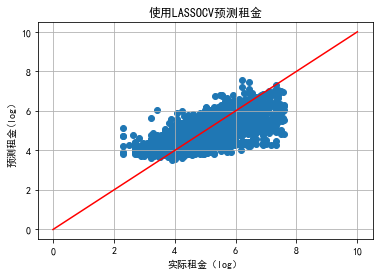

In [151]:
plt.scatter(y_test, y_test_pred)
plt.grid(True)
plt.plot([0, 10], [0, 10], color="red")
plt.title("使用LASSOCV预测租金")
plt.xlabel("实际租金（log）")
plt.ylabel("预测租金(log）")


**<font size=4>使用LARS Path确定哪些功能最重要</font>**

LARS路径是查看LassoCV模型中哪些功能最重要/最不重要的好工具。简而言之，在下图中，从零开始（正或负）变化的特征最重要，而最后变为非零的特征最不重要。也就是说，左侧出现的功能最为重要。这些特征的beta系数也反映了这一点。

In [152]:
print("使用LARS计算正则化路径")
alphas, _, coefs = lars_path(X_train_scaled, y_train, method="lasso")

使用LARS计算正则化路径


In [153]:
xx = np.sum(np.abs(coefs.T),axis=1)

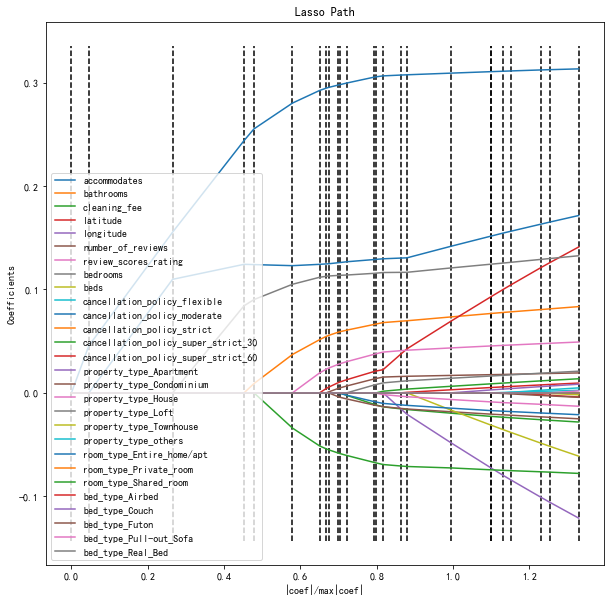

In [154]:
plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyles="dashed")
plt.xlabel("|coef|/max|coef|")
plt.ylabel("Coefficients")
plt.title("Lasso Path")
plt.axis("tight")
plt.legend(features.columns)
plt.show()